# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [8]:
data_path = '/data/parameter_estimation/interferon_data/20200412/'

In [9]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x,limit=1e3, **kwargs):
    
    condition = np.isfinite(x) & (x < limit)
    sns.distplot(x[condition], **kwargs)

def robust_perc(x, q):
    
    condition = np.isfinite(x)
    return np.percentile(x[condition], q)

### Perform some basic filtering

In [10]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [11]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [12]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


In [13]:
def simplify_name(name):
    return name.split('.')[0]

known_gene_df = pd.read_csv(data_path + 'chipseq/gene_locations_2.bed', header=0, sep='\t')#[[4, 5]]
known_gene_df['gene_name'] = known_gene_df['transcript'].apply(simplify_name)
known_gene_df['gene_ids'] = known_gene_df['protein'].apply(simplify_name)

new_var = adata.var.merge(known_gene_df, on='gene_ids', how='left')
new_var.index = adata.var.index
adata.var = new_var.copy()

In [14]:
%matplotlib inline

... storing '#chrom' as categorical
... storing 'transcript' as categorical
... storing 'protein' as categorical
... storing 'gene_name' as categorical


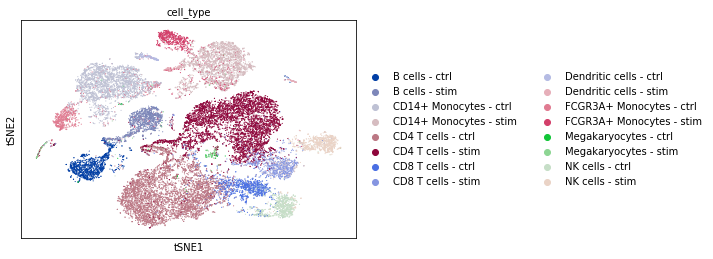

In [15]:
sc.pl.tsne(adata, color='cell_type')

In [16]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [17]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


In [18]:
adata.shape

(24673, 3593)

### Select immune genes using GO annotations

In [19]:
go_annotations = pd.read_csv(data_path + '../../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [20]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [21]:
immune_genes = list(set(adata.var.index) & set(immune_genes))

In [22]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(immune_genes, f)

In [23]:
len(immune_genes)

855

### Pick out TFs to measure DC in

In [24]:
tfs = pd.read_csv('gene_attribute_matrix.txt', sep='\t').columns.tolist()[3:]
tfs_in_highcount = list(set(tfs) & set(adata.var.index))
manual_tfs = """IRF2BP2
STAT4
IRF2
ATF6B
IRF7
STAT6
IRF9
IRF8
AATF
JUNB
ATF5
ATF4""".split()
tfs_to_consider = manual_tfs + tfs_in_highcount

In [25]:
for gene in adata.var.index:
    if ('JUN' in gene or 'ATF' in gene or 'FOS' in gene or 'STAT' in gene or 'IRF' in gene) and (gene not in tfs_in_highcount):
        print(gene)

IRF2BP2
STAT4
IRF2
ATF6B
IRF7
STAT6
IRF9
IRF8
AATF
JUNB
ATF5
ATF4


In [26]:
with open(data_path + 'all_highcount_tfs.pkl', 'wb') as f:
    pkl.dump(tfs_to_consider, f)

In [27]:
len(set(tfs_to_consider))

68

### Read the DC results into long form and heatmaps

In [44]:
tf_batch_nums = np.arange(14)
cts = ['CD4 T cells', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']

In [45]:
heatmaps = {}
ct_dfs = []
for ct in cts:
    heatmaps[ct] = {}
    
    df_list = []
    for tf_batch_num in tf_batch_nums:
        with open(data_path + 'tf_correlations/stim_effect_2d_{}_{}.pkl'.format(ct, tf_batch_num), 'rb') as f:
            dc_dict = pkl.load(f)
            
        first = True
        for attribute, value in dc_dict.items():
            
            if 'gene_idx' in attribute: continue
                        
            # Create the TF x Gene heatmap for each attribute
            attribute_df = pd.DataFrame(
                dc_dict[attribute], 
                index=adata.var.index[dc_dict['gene_idx_1']],
                columns=adata.var.index[dc_dict['gene_idx_2']]).T
            
            # Create attribute heatmaps
            if tf_batch_num == 0:
                heatmaps[ct][attribute] = attribute_df.copy()
            else:
                heatmaps[ct][attribute] = pd.concat([heatmaps[ct][attribute], attribute_df], axis=1)
                
            # Create melted dataframes for easy querying
            attribute_df['gene'] = attribute_df.index
            melted_attribute_df = pd.melt(
                attribute_df, 
                id_vars=['gene'], 
                value_vars=attribute_df.columns[:-1], 
                var_name='tf', value_name=attribute)
            
            # Add columns instead of join for speed
            if first:
                df = melted_attribute_df.copy()
                first=False
            else:
                df[attribute] = melted_attribute_df[attribute]
        
        df_list.append(df)
    ct_df = pd.concat(df_list)
    ct_df['ct'] = ct
    ct_dfs.append(ct_df)
dc_df = pd.concat(ct_dfs)
dc_df['mag_corr_diff'] = dc_df['corr_2'].abs() - dc_df['corr_1'].abs()



### Calibration histogram

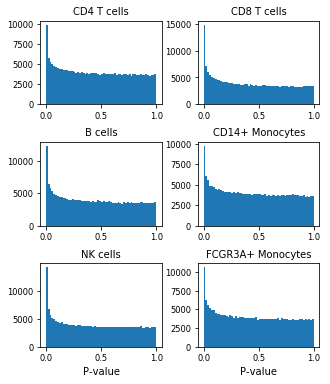

In [41]:
plt.figure(figsize=(5, 6))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

for idx, ct in enumerate(cts):
    plt.subplot(3, 2, idx+1)
    plt.title(ct)
    data = dc_df.query('ct == "{}"'.format(ct))
    plt.hist(data['dcorr_pval'], bins=60)
    
    if idx == 5 or idx == 4:
        plt.xlabel('P-value')
plt.savefig('dc_calibration.pdf', bbox_inches='tight')


### Get some numbers for the paper

In [46]:
dc_df.query('dcorr_fdr < 0.1')[['tf', 'gene']].drop_duplicates().shape

(19522, 2)

In [47]:
dc_df.query('dcorr_fdr < 0.1').groupby('ct').size()

ct
B cells              3634
CD14+ Monocytes      1763
CD4 T cells          2041
CD8 T cells          5570
FCGR3A+ Monocytes    2054
NK cells             5537
dtype: int64

### Correlation distributions

Ks_2sampResult(statistic=0.20595602560534373, pvalue=4.412246824036374e-67)
Ks_2sampResult(statistic=0.12051210687447815, pvalue=3.8617842141197625e-23)
Ks_2sampResult(statistic=0.2257166713053159, pvalue=1.326992936124356e-80)
Ks_2sampResult(statistic=0.08934038408015586, pvalue=6.781674378482616e-13)
Ks_2sampResult(statistic=0.08516559977734484, pvalue=9.351518005763973e-12)
Ks_2sampResult(statistic=0.3701642081825772, pvalue=2.2385280626246815e-219)


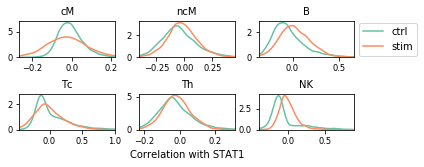

In [948]:
label_mapping = {
    'CD14+ Monocytes':'cM',
    'FCGR3A+ Monocytes':'ncM',
    'B cells':'B',
    'CD8 T cells':'Tc',
    'CD4 T cells':'Th',
    'NK cells':'NK'
}

plt.figure(figsize=(6, 2));
plt.subplots_adjust(hspace=1, wspace=0.25)

sns.set_palette('Set2')
tf = 'STAT2'
for ct_idx, ct in enumerate(['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']):


        plt.subplot(2, 3, ct_idx+1)

        corr_1 = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['corr_1']
        corr_2 = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['corr_2']
        corr_diff = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['dcorr_diff']
        
        print(stats.ks_2samp(corr_1, corr_2))

        robust_hist(corr_1, hist=False, label='ctrl' if ct == 'B cells' else None)
        robust_hist(corr_2, hist=False, label='stim' if ct == 'B cells' else None)
        #robust_hist(corr_diff, hist=False)

        perc_lim = 1
        x_min = min(robust_perc(corr_1, perc_lim), robust_perc(corr_2, perc_lim))
        x_max = max(robust_perc(corr_1, 100-perc_lim), robust_perc(corr_2, 100-perc_lim))

        plt.xlim(x_min, x_max)
        #plt.legend()
        #plt.title(ct)

        plt.title(label_mapping[ct])

        plt.xlabel('')

        if ct == 'B cells':
            plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


#     if ct == 'NK cells':
#         plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
        if ct == 'CD4 T cells':
            plt.xlabel('Correlation with STAT1')
#plt.savefig('stat1_correlation_dists.pdf', bbox_inches='tight')

### Check if the STAT1 DC genes are enriched for STAT1 binding CHIP-seq peaks

In [625]:
# Baseline
!/home/mkim7/tools/bedtools closest \
    -a /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/ENCFF323QQU.sorted.bed \
    -b /data/parameter_estimation/interferon_data/20200412/chipseq/gene_tss_windows_1000.bed -d  > \
    /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/stat1_genes_baseline.bed

In [823]:
# Short
!/home/mkim7/tools/bedtools closest \
    -a /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/ENCFF646MXG.sorted.bed \
    -b /data/parameter_estimation/interferon_data/20200412/chipseq/gene_tss_windows_20000.bed -d  > \
    /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/stat1_genes_30min.bed

In [824]:
# Stim
!/home/mkim7/tools/bedtools closest \
    -a /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/ENCFF747ICD.sorted.bed \
    -b /data/parameter_estimation/interferon_data/20200412/chipseq/gene_tss_windows_20000.bed -d  > \
    /data/parameter_estimation/interferon_data/20200412/chipseq/stat1/stat1_genes_6hr.bed

In [28]:
highcount_genes = adata.var.copy()
highcount_genes['gene'] = highcount_genes.index.tolist()

In [29]:
baseline = pd.read_csv(data_path + 'chipseq/stat1/stat1_genes_baseline.bed', sep='\t', header=None).iloc[:, [-2, -1]]
baseline.columns=['gene_name', 'distance']
baseline = baseline.query('distance == 0')
baseline = baseline.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
baseline = baseline['gene'].drop_duplicates().tolist()

short_stim = pd.read_csv(data_path + 'chipseq/stat1/stat1_genes_30min.bed', sep='\t', header=None).iloc[:, [-2, -1]]
short_stim.columns=['gene_name', 'distance']
short_stim = short_stim.query('distance == 0')
short_stim = short_stim.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
short_stim = short_stim['gene'].drop_duplicates().tolist()

stim = pd.read_csv(data_path + 'chipseq/stat1/stat1_genes_6hr.bed', sep='\t', header=None).iloc[:, [-2, -1]]
stim.columns=['gene_name', 'distance']
stim = stim.query('distance == 0')
stim = stim.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
stim = stim['gene'].drop_duplicates().tolist()

isgf3 = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3.columns=['gene_name', 'distance']
isgf3 = isgf3.query('distance == 0')
isgf3 = isgf3.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
isgf3 = isgf3['gene'].drop_duplicates().tolist()

In [30]:
chipseq_genes = isgf3#stim#set(isgf3)# - set(baseline)#list(set(short_stim + stim + baseline))

### Fit some estimators

In [22]:
%matplotlib inline

0.09688301 0.0799701
CD14+ Monocytes Ttest_indResult(statistic=1.4870420426909912, pvalue=0.1370958910806422)
0.12796296 0.08849932
FCGR3A+ Monocytes Ttest_indResult(statistic=2.150414998877223, pvalue=0.03159628942193221)
0.19587865 0.12904721
B cells Ttest_indResult(statistic=3.010907013733379, pvalue=0.002625250600583642)
nan nan
CD8 T cells Ttest_indResult(statistic=nan, pvalue=nan)
-0.05240637 -0.08667772
CD4 T cells Ttest_indResult(statistic=3.0549443195355708, pvalue=0.002268377657645883)
-0.01579949 -0.07857002
NK cells Ttest_indResult(statistic=2.5646839774942745, pvalue=0.010377288024118098)


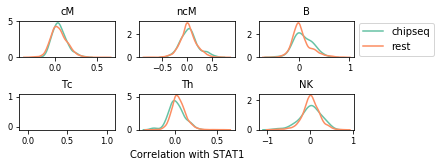

In [31]:
imp.reload(scmemo)
cts=['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']
idx = adata.var.index.tolist().index('STAT1')
label_mapping = {
    'CD14+ Monocytes':'cM',
    'FCGR3A+ Monocytes':'ncM',
    'B cells':'B',
    'CD8 T cells':'Tc',
    'CD4 T cells':'Th',
    'NK cells':'NK'
}

estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.compute_observed_moments(verbose=False)
estimator.estimate_beta_sq(tolerance=0)
#estimator.plot_cv_mean_curve()
#estimator.beta_sq =0.01


estimator.estimate_1d_parameters()
estimator.estimate_2d_parameters(
    gene_list_1=['STAT1'], 
    gene_list_2=adata.var.index.tolist(),
    groups=[ct + ' - ctrl' for ct in cts] + [ct + ' - stim' for ct in cts])

plt.figure(figsize=(6, 2));
plt.subplots_adjust(hspace=1, wspace=0.25)

sns.set_palette('Set2')
dfs=[]
for ct_idx, ct in enumerate(cts):


    plt.subplot(2, 3, ct_idx+1)
    
    df = pd.DataFrame()
    df['gene'] = adata.var.index.tolist()
    df['corr_1'] = estimator.parameters[ct + ' - ctrl']['corr'][idx, :].toarray()[0]
    df['corr_2'] = estimator.parameters[ct + ' - stim']['corr'][idx, :].toarray()[0]
    df['diff'] = df['corr_2']# - df['corr_1']
    df['mag_diff'] = df['corr_2'].abs() - df['corr_1'].abs()
    df['chipseq'] = df['gene'].apply(lambda x: x in chipseq_genes)
    df['ct'] = ct
#     print(df.head(10))

    df = df.query('corr_1 > -1 & corr_1 < 1 & corr_2 > -1 & corr_2 < 1')
    dfs.append(df)
    
    print(df.query('chipseq')['diff'].dropna().mean(), df.query('~chipseq')['diff'].dropna().mean())
    
    print(ct, stats.ttest_ind(df.query('chipseq')['diff'].dropna(), df.query('~chipseq')['diff'].dropna()))

    robust_hist(df.query('chipseq')['mag_diff'], label='chipseq' if ct == 'B cells' else None, hist=False)
    robust_hist(df.query('~chipseq')['mag_diff'], label='rest' if ct == 'B cells' else None, hist=False)
    
#     perc_lim = 1
#     x_min = min(robust_perc(corr_1, perc_lim), robust_perc(corr_2, perc_lim))
#     x_max = max(robust_perc(corr_1, 100-perc_lim), robust_perc(corr_2, 100-perc_lim))

#     plt.xlim(x_min, x_max)
    #plt.legend()
    #plt.title(ct)

    plt.title(label_mapping[ct])

    plt.xlabel('')

    if ct == 'B cells':
        plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


#     if ct == 'NK cells':
#         plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')

    if ct == 'CD4 T cells':
        plt.xlabel('Correlation with STAT1')
df = pd.concat(dfs)
plt.show()

In [35]:
x = np.log(estimator.estimated_central_moments['all']['first'])
y = np.log(estimator.estimated_central_moments['all']['second'])

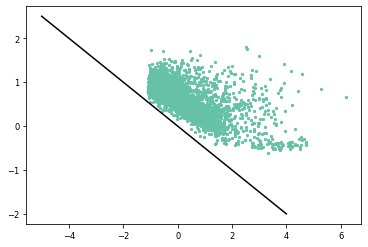

In [39]:
plt.scatter(x, y/2-x, s=5)
plt.plot(np.array([-5, 4]), -np.array([-5, 4])/2,'k')


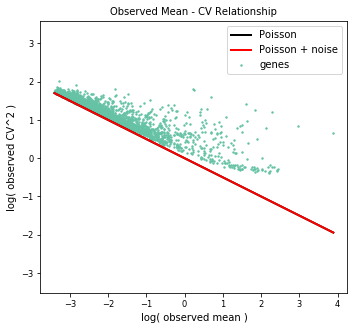

In [33]:
estimator.plot_cv_mean_curve()

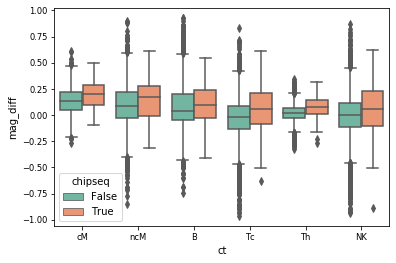

In [34]:

sns.boxplot(x='ct', y='mag_diff', data=df, hue='chipseq')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['cM', 'ncM', 'B', 'Tc', 'Th', 'NK'])
plt.show()

In [40]:
%matplotlib nbagg


In [1112]:
ct = 'CD14+ Monocytes'

In [1120]:
df = pd.DataFrame()
df['gene'] = adata.var.index.tolist()
df['corr_1'] = estimator.parameters[ct + ' - ctrl']['corr'][idx, :].toarray()[0]
df['corr_2'] = estimator.parameters[ct + ' - stim']['corr'][idx, :].toarray()[0]
df['diff'] = df['corr_2'] - df['corr_1']
df['mag_diff'] = df['corr_2'].abs() - df['corr_1'].abs()
df['chipseq'] = df['gene'].apply(lambda x: x in chipseq_genes)
df = df.query('corr_1 > -1 & corr_1 < 1 & corr_2 > -1 & corr_2 < 1')

In [1121]:
len(chipseq_genes)

112

(-0.5, 0.5)

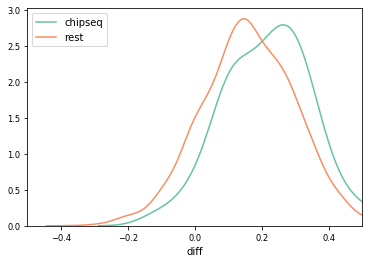

In [1122]:
robust_hist(df.query('chipseq')['diff'], label='chipseq', hist=False)
robust_hist(df.query('~chipseq')['diff'], label='rest', hist=False)
plt.legend()
plt.xlim(-.5, .5)

In [1124]:
stats.ks_2samp(df.query('chipseq')['diff'], df.query('~chipseq')['diff'])

Ks_2sampResult(statistic=0.19614587296287958, pvalue=0.0004213024521714237)

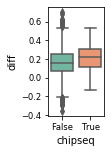

In [1125]:
plt.figure(figsize=(1, 2))
sns.boxplot(x='chipseq', y='diff', data=df)
#plt.ylim(-0.4, 0.4)

In [846]:
def stat1 = get_data('CD14+ Monocytes', 'STAT1')
isg15 = get_data('CD14+ Monocytes', 'ISG15')(ct, gene_idx):
    
    return\
        (adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X,
        adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X)

In [41]:
stat1 = get_data('CD14+ Monocytes', 'STAT1')
isg15 = get_data('CD14+ Monocytes', 'ISG15')

NameError: name 'get_data' is not defined

In [861]:
stats.spearmanr(
    get_data('CD14+ Monocytes', 'STAT1')[1], 
    get_data('CD14+ Monocytes', 'IFIT1')[1]
)

SpearmanrResult(correlation=0.2951386034282447, pvalue=2.0340709425145304e-53)

In [862]:
stats.spearmanr(
    get_data('CD14+ Monocytes', 'STAT1')[0], 
    get_data('CD14+ Monocytes', 'IFIT1')[0]
)

SpearmanrResult(correlation=0.08650985202420285, pvalue=4.8328355892241215e-06)

In [856]:
stats.pearsonr(
    get_data('CD14+ Monocytes', 'STAT1')[1], 
    get_data('CD14+ Monocytes', 'SSU72')[1]
)

(0.05656606611757644, 0.003911178925461511)

In [851]:
dc_df.query('tf == "STAT1" & gene == "ISG15"')

,gene,tf,dcov_diff,dcov_pval,dcov_fdr,cov_1,cov_2,dcorr_diff,dcorr_pval,dcorr_fdr,corr_1,corr_2,ct,mag_corr_diff
14374,ISG15,STAT1,12.169904,0.482152,0.873554,0.491107,12.661011,0.021621,0.972903,0.998255,0.043481,0.065102,CD4 T cells,0.021621
14374,ISG15,STAT1,61.173954,0.001325,0.055994,-0.197407,60.976547,0.377618,0.000007,0.000830,-0.088394,0.289224,CD8 T cells,0.200829
14374,ISG15,STAT1,359.045898,0.001200,0.053209,1.168629,360.214539,0.313688,0.183382,0.614785,0.223943,0.537631,B cells,0.313688
14374,ISG15,STAT1,120.363838,0.253775,0.704450,7.781670,128.145508,-0.005643,0.889311,0.983468,0.065550,0.059907,CD14+ Monocytes,-0.005643
14374,ISG15,STAT1,8.099020,0.486551,0.862632,0.433054,8.532074,0.015630,0.868313,0.976033,0.044668,0.060298,NK cells,0.015630
14374,ISG15,STAT1,391.214050,0.041996,0.377500,10.591618,401.805664,0.115895,0.318568,0.827770,0.078226,0.194120,FCGR3A+ Monocytes,0.115895


In [839]:
stat1_dc_df = dc_df.query('tf == "STAT1"')#.sort_values('dcorr_fdr').drop_duplicates('gene')#.gene.drop_duplicates().tolist()
stat1_dc_df['sig'] = stat1_dc_df['dcorr_fdr'] < 2
stat1_dc_df['in_chipseq'] = stat1_dc_df.gene.apply(lambda x: x in chipseq_genes)

In [840]:
stat1_dc_df.query('~in_chipseq')['mag_corr_diff'].shape

(19962,)

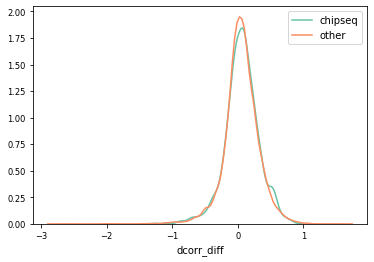

In [842]:
robust_hist(stat1_dc_df.query('in_chipseq')['dcorr_diff'], label='chipseq', hist=False)
robust_hist(stat1_dc_df.query('~in_chipseq')['dcorr_diff'], label='other', hist=False)

# robust_hist(stat1_dc_df.query('in_chipseq')['dcorr_diff'], label='chipseq', hist=False)
# robust_hist(stat1_dc_df.query('~in_chipseq')['dcorr_diff'], label='other', hist=False)
#plt.xlim(-0.5, 0.75)

In [726]:
stat1_dc_df = dc_df.query('tf == "STAT1"')#.sort_values('dcorr_fdr').drop_duplicates('gene')#.gene.drop_duplicates().tolist()
stat1_dc_df['sig'] = stat1_dc_df['dcorr_fdr'] < 0.1
stat1_dc_df['in_chipseq'] = stat1_dc_df.gene.apply(lambda x: x in chipseq_change)

In [727]:
pd.crosstab(stat1_dc_df['sig'], stat1_dc_df['in_chipseq']).values

array([[20163,   871],
       [  501,    23]])

### Corr diff distributions

In [732]:
ct = 'CD14+ Monocytes'

Ks_2sampResult(statistic=0.053248687757128654, pvalue=0.05176608522436929)


(-1, 1.0)

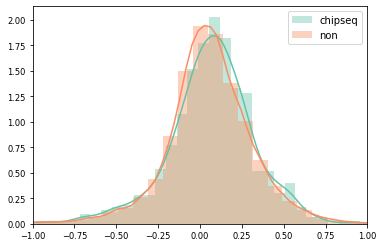

In [783]:
chipseq_diffs = dc_df.query('tf == "STAT1" & gene in @chipseq_genes'.format(ct)).dcorr_diff.values
nonchipseq_diffs = dc_df.query('tf == "STAT1" & gene not in @chipseq_genes'.format(ct)).dcorr_diff.values
print(stats.ks_2samp(chipseq_diffs[np.isfinite(chipseq_diffs)], nonchipseq_diffs[np.isfinite(nonchipseq_diffs)]))

robust_hist(chipseq_diffs, label='chipseq')
robust_hist(nonchipseq_diffs, label='non')
plt.legend()
plt.xlim(-1, 1.0)

Ks_2sampResult(statistic=0.08306918190854251, pvalue=0.005019795780485823)


(-1, 1.0)

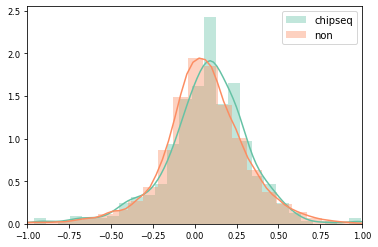

In [496]:
chipseq_diffs = dc_df.query('tf == "STAT1" & gene in @chipseq_genes'.format(ct)).dcorr_diff.values
nonchipseq_diffs = dc_df.query('tf == "STAT1" & gene not in @chipseq_genes'.format(ct)).dcorr_diff.values
print(stats.ks_2samp(chipseq_diffs[np.isfinite(chipseq_diffs)], nonchipseq_diffs[np.isfinite(nonchipseq_diffs)]))

robust_hist(chipseq_diffs, label='chipseq')
robust_hist(nonchipseq_diffs, label='non')
plt.legend()
plt.xlim(-1, 1.0)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd8b0bef110>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd8a11ffd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd8b0b30650>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd8a2be0fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd8a2be02d0>,
 'means': []}

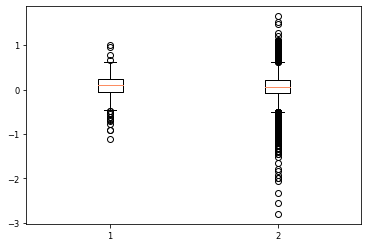

In [498]:
plt.boxplot([chipseq_diffs[np.isfinite(chipseq_diffs)], nonchipseq_diffs[np.isfinite(nonchipseq_diffs)]])

### Selection process for TFs - Logistic Regression

In [46]:
ct = 'CD14+ Monocytes'

In [47]:
# Set up the data

stim_corr_mat = heatmaps[ct]['corr_2'].copy().abs()#.drop('gene', axis=1)
stim_corr_mat[~np.isfinite(stim_corr_mat)] = 0
stim_corr_mat[stim_corr_mat > 0.8] = 0
stim_corr_mat['gene'] = stim_corr_mat.index
stim_corr_mat['stim'] = 'stim'

ctrl_corr_mat = heatmaps[ct]['corr_1'].copy().abs()#.drop('gene', axis=1)
ctrl_corr_mat[~np.isfinite(ctrl_corr_mat)] = 0
ctrl_corr_mat[ctrl_corr_mat > 0.8] = 0
ctrl_corr_mat['stim'] = 'control'
ctrl_corr_mat['gene'] = ctrl_corr_mat.index

corr_mat = pd.concat([stim_corr_mat, ctrl_corr_mat])#[['SPI1', 'STAT1', 'STAT2','FOS','IRF2','gene', 'stim']]#.dropna(axis=1)
X = corr_mat.iloc[:, :-2]
# X[~np.isfinite(X)] = 0
# X[X > 1] = 1
y = corr_mat['stim']

In [48]:
X.shape

(7186, 68)

In [1024]:
# Train the classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', C=0.2)
clf.fit(X, y)
corr_mat['stim_pred'] = clf.predict(X)
corr_mat['stim_prob'] = clf.predict_proba(X)[:, 1]
corr_mat['abs_prob'] = corr_mat['stim_prob']*(corr_mat['stim_prob'] > 0.5) + (1-corr_mat['stim_prob'])*(corr_mat['stim_prob'] < 0.5)
corr_mat['logit'] = np.log(corr_mat['stim_prob'] / (1-corr_mat['stim_prob']))
corr_mat['mag_logit'] = corr_mat['logit'].abs()

print('accuracy:', (corr_mat['stim_pred'] == y).mean())
print('Number of nonzero coef:', (clf.coef_!=0).sum())

accuracy: 0.9152518786529362
Number of nonzero coef: 46


In [1025]:
from sklearn.model_selection import cross_validate
score = cross_validate(clf, X, y, cv=50)
print('cross validation mean test acc:', score['test_score'].mean())

cross validation mean test acc: 0.9123454616588418


In [1026]:
coef_df = pd.DataFrame()
coef_df['tf'] = X.columns
coef_df['coef'] = clf.coef_[0]

In [1027]:
num_tfs = 10

In [1028]:
stim_tf = coef_df.query('coef > 0').sort_values('coef').tail(num_tfs).tf.tolist()
ctrl_tf = coef_df.query('coef < 0').sort_values('coef').head(num_tfs).tf.tolist()[::-1]

In [1040]:
print('stim', stim_tf)
print('ctrl', ctrl_tf)

stim ['STAT2', 'NR3C1', 'HDAC1', 'CREB1', 'ZNF274', 'SMC3', 'CHD1', 'HDAC2', 'STAT1', 'E2F4']
ctrl ['JUND', 'STAT4', 'CBX3', 'CEBPB', 'HSF1', 'NCOR1', 'THAP1', 'STAT6', 'BCLAF1', 'SMARCC1']


In [1030]:
num_genes_from_each = 50
candidate_genes = \
    corr_mat.query('stim == "control"').sort_values('mag_logit', ascending=False).head(num_genes_from_each).gene.drop_duplicates().tolist() + \
    corr_mat.query('stim == "stim"').sort_values('mag_logit', ascending=False).head(num_genes_from_each).gene.drop_duplicates().tolist()

### Selection process for TFs - DC hits

In [28]:
ct = 'CD14+ Monocytes'

In [29]:
count_df = pd.DataFrame()
count_df['tf'] = tfs_to_consider
count_df['inc_mag_corr'] = [
    dc_df.query('ct == "{}" & dcorr_fdr < 0.05 & tf == "{}" & mag_corr_diff > 0'.format(ct, tf)).shape[0] for tf in tfs_to_consider
]
count_df['dec_mag_corr'] = [
    dc_df.query('ct == "{}" & dcorr_fdr < 0.05 & tf == "{}" & mag_corr_diff < 0'.format(ct, tf)).shape[0] for tf in tfs_to_consider
]
count_df['diff'] = count_df['inc_mag_corr'] - count_df['dec_mag_corr']
count_df['inc_prob'] = count_df['inc_mag_corr'] / (count_df['inc_mag_corr'] + count_df['dec_mag_corr'])

In [30]:
count_df.sort_values('diff').tail(10)

,tf,inc_mag_corr,dec_mag_corr,diff,inc_prob
65,CREB1,13,5,8,0.722222
46,NELFE,12,1,11,0.923077
67,ZNF274,23,10,13,0.696970
37,E2F4,17,2,15,0.894737
52,JUN,15,0,15,1.000000
47,ETS1,71,54,17,0.568000
39,SMC3,21,4,17,0.840000
28,HDAC2,32,9,23,0.780488
4,IRF7,60,23,37,0.722892
17,STAT1,98,2,96,0.980000


In [31]:
ctrl_tf = count_df.sort_values('diff').head(10)['tf'].tolist()
stim_tf = count_df.sort_values('diff').tail(10)['tf'].tolist()

# import random
# random.shuffle(ctrl_tf)
# random.shuffle(stim_tf)

In [32]:
print('stim', stim_tf)
print('ctrl', ctrl_tf)

stim ['CREB1', 'NELFE', 'ZNF274', 'E2F4', 'JUN', 'ETS1', 'SMC3', 'HDAC2', 'IRF7', 'STAT1']
ctrl ['GATA3', 'CEBPB', 'STAT4', 'MYC', 'SMARCC1', 'BCLAF1', 'HSF1', 'BDP1', 'BACH1', 'IRF8']


In [34]:
ctrl_tf = ['BCLAF1','HSF1','SMARCC1','CEBPB', 'STAT4', 'MYC', 'BDP1', 'BACH1', 'IRF8', 'GATA3'][::-1]

In [109]:
#num_genes_from_each = 500
ctrl_candidate_genes = dc_df.query('ct == "{}" & dcorr_fdr < 0.1 & tf in @ctrl_tf'.format(ct)).sort_values('mag_corr_diff').gene.drop_duplicates().tolist()
stim_candidate_genes = dc_df.query('ct == "{}" & dcorr_fdr < 0.1 & tf in @stim_tf'.format(ct)).sort_values('mag_corr_diff', ascending=False).gene.drop_duplicates().tolist()

candidate_genes = list(set(ctrl_candidate_genes) & set(stim_candidate_genes))


In [89]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    test_dict = pkl.load(f)

In [91]:
def get_key(ct):
    return (ct + ' - ctrl', ct + ' - stim')
ct = 'CD14+ Monocytes'
upreg_genes = utils.get_differential_genes(
    gene_list=adata.var.index.tolist(),
    hypothesis_test_dict=test_dict,
    group_1 = get_key(ct)[0],
    group_2 = get_key(ct)[1],
    which='mean',
    direction='increase',
    sig=0.05,
    num_genes=5000
    )['gene'].tolist()

### Network drawing - monocytes

In [156]:
ct = 'CD14+ Monocytes'

In [157]:
all_genes_considered = list(set(candidate_genes) - set(ctrl_tf) - set(stim_tf))

In [158]:
import networkx as nx

In [159]:
imp.reload(scmemo)

<module 'scmemo' from '/home/mkim7/Github/scrna-parameter-estimation/scmemo/scmemo.py'>

In [160]:
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.compute_observed_moments(verbose=False)
estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_1d_parameters()
estimator.estimate_2d_parameters(
    gene_list_1=all_genes_considered, 
    gene_list_2=all_genes_considered,
    groups=[ct + ' - ctrl', ct + ' - stim'])
idxs = estimator._get_gene_idxs(all_genes_considered)

In [161]:
# Get correlations between target genes
ctrl_target_corrs = pd.DataFrame(
    data=estimator.parameters[ct + ' - ctrl']['corr'][idxs, :][:, idxs].toarray(),
    index=all_genes_considered,
    columns=all_genes_considered)
ctrl_target_corrs[ctrl_target_corrs > 1] = 1
ctrl_target_corrs[ctrl_target_corrs < -1] = -1

stim_target_corrs = pd.DataFrame(
    data=estimator.parameters[ct + ' - stim']['corr'][idxs, :][:, idxs].toarray(),
    index=all_genes_considered,
    columns=all_genes_considered)
stim_target_corrs[stim_target_corrs > 1] = 1
stim_target_corrs[stim_target_corrs < -1] = -1

In [162]:
# Set up the data

stim_corr_mat = heatmaps[ct]['corr_2'].copy().abs()#.drop('gene', axis=1)
stim_corr_mat[~np.isfinite(stim_corr_mat)] = 0
stim_corr_mat[stim_corr_mat > 0.8] = 0
stim_corr_mat['gene'] = stim_corr_mat.index
stim_corr_mat['stim'] = 'stim'

ctrl_corr_mat = heatmaps[ct]['corr_1'].copy().abs()#.drop('gene', axis=1)
ctrl_corr_mat[~np.isfinite(ctrl_corr_mat)] = 0
ctrl_corr_mat[ctrl_corr_mat > 0.8] = 0
ctrl_corr_mat['stim'] = 'control'
ctrl_corr_mat['gene'] = ctrl_corr_mat.index

corr_mat = pd.concat([stim_corr_mat, ctrl_corr_mat])#[['SPI1', 'STAT1', 'STAT2','FOS','IRF2','gene', 'stim']]#.dropna(axis=1)
X = corr_mat.iloc[:, :-2]
# X[~np.isfinite(X)] = 0
# X[X > 1] = 1
y = corr_mat['stim']

In [163]:
# Create the control graph
ctrl_G = nx.Graph()
ctrl_G.add_nodes_from(ctrl_tf + stim_tf + all_genes_considered)
for tf in stim_tf + ctrl_tf:
    for gene in all_genes_considered:
        ctrl_G.add_edge(tf, gene, weight=ctrl_corr_mat.loc[gene, tf])
for g1 in all_genes_considered:
    for g2 in all_genes_considered:
        if g1 == g2: continue
        ctrl_G.add_edge(g1, g2, weight=ctrl_target_corrs.loc[g1, g2])

# # Create the stim graph
stim_G = nx.Graph()
stim_G.add_nodes_from(ctrl_tf + stim_tf + all_genes_considered)
for tf in stim_tf + ctrl_tf:
    for gene in all_genes_considered:
        stim_G.add_edge(tf, gene, weight=stim_corr_mat.loc[gene, tf])
for g1 in all_genes_considered:
    for g2 in all_genes_considered:
        if g1 == g2: continue
        stim_G.add_edge(g1, g2, weight=stim_target_corrs.loc[g1, g2])

In [184]:
# Generate the positions
pos = {}

tf_heights = np.linspace(-6, 6, len(stim_tf))

# Get new tf_heights (spread out the highlighting)
new_tf_heights = []
for idx in range(5):
    new_tf_heights.append(tf_heights[idx])
    new_tf_heights.append(tf_heights[-(idx+1)])
    
for height, tf in zip(new_tf_heights, stim_tf):
    pos[tf] = (np.random.uniform(-6.5, -5.5), height)
for height, tf in zip(new_tf_heights[::-1], ctrl_tf):
    print(height, tf)
    
    pos[tf] = (np.random.uniform(5.5, 6.5) if tf != 'SMARCC1' else 5.6, height)

for gene in all_genes_considered:
    pos[gene] = np.array([np.random.uniform(-1, 1), np.random.uniform(-10, 10)])

# Do positioning for labels
label_pos = {}
for tf in stim_tf:
    label_pos[tf] = (pos[tf][0] - 1.7, pos[tf][1])
for tf in ctrl_tf:
    label_pos[tf] = (pos[tf][0] + 1.7, pos[tf][1])
    

0.6666666666666661 GATA3
-0.666666666666667 IRF8
2.0 BACH1
-2.0 BDP1
3.333333333333332 MYC
-3.3333333333333335 STAT4
4.666666666666666 CEBPB
-4.666666666666667 SMARCC1
6.0 HSF1
-6.0 BCLAF1


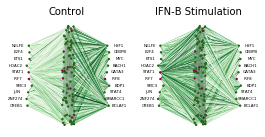

In [185]:
plt.figure(figsize=(4.5, 2), frameon=False)
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.1)

edge_colors = np.array([ctrl_G[u][v]['weight'] for u,v in ctrl_G.edges])
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    with_labels=False, 
    width=[0.01 if source in all_genes_considered and sink in all_genes_considered else 0.5 for source, sink in ctrl_G.edges()], 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=2,
    edge_vmin=0,
    edge_vmax=0.3,
    node_color=[0 if node in upreg_genes else 1 for node in ctrl_G.nodes()],
    cmap=mpl.cm.PiYG,
    vmin=0,
    vmax=1,
    node_shape='8')
nx.draw_networkx_labels(G=ctrl_G, pos=label_pos, labels={tf:tf for tf in ctrl_tf + stim_tf}, font_size=4)
plt.xlim(-9.5, 9)
plt.axis('off')
plt.title('Control')


plt.subplot(1, 2, 2)
edge_colors = np.array([stim_G[u][v]['weight'] for u,v in stim_G.edges])
nx.draw_networkx(
    stim_G, 
    pos=pos, 
    with_labels=False, 
    width=[0.01 if source in all_genes_considered and sink in all_genes_considered else 0.5 for source, sink in stim_G.edges()], 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=2,
    edge_vmin=0, 
    edge_vmax=0.3,
    node_color=[0 if node in upreg_genes else 1 for node in ctrl_G.nodes()],
    cmap=mpl.cm.PiYG,
    vmin=0,
    vmax=1,
    node_shape='8')
nx.draw_networkx_labels(G=ctrl_G, pos=label_pos, labels={tf:tf for tf in ctrl_tf + stim_tf}, font_size=4)
plt.xlim(-9.5, 9)
plt.axis('off')
plt.title('IFN-B Stimulation')


plt.savefig('network_switching_2.png', bbox_inches='tight', dpi=300)

### Network drawing - CD4 T cells

In [186]:
ct = 'CD4 T cells'

In [187]:
all_genes_considered = list(set(candidate_genes) - set(ctrl_tf) - set(stim_tf))

In [188]:
import networkx as nx

In [189]:
imp.reload(scmemo)

<module 'scmemo' from '/home/mkim7/Github/scrna-parameter-estimation/scmemo/scmemo.py'>

In [190]:
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.compute_observed_moments(verbose=False)
estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_1d_parameters()
estimator.estimate_2d_parameters(
    gene_list_1=all_genes_considered, 
    gene_list_2=all_genes_considered,
    groups=[ct + ' - ctrl', ct + ' - stim'])
idxs = estimator._get_gene_idxs(all_genes_considered)

In [191]:
# Get correlations between target genes
ctrl_target_corrs = pd.DataFrame(
    data=estimator.parameters[ct + ' - ctrl']['corr'][idxs, :][:, idxs].toarray(),
    index=all_genes_considered,
    columns=all_genes_considered)
ctrl_target_corrs[ctrl_target_corrs > 1] = 1
ctrl_target_corrs[ctrl_target_corrs < -1] = -1

stim_target_corrs = pd.DataFrame(
    data=estimator.parameters[ct + ' - stim']['corr'][idxs, :][:, idxs].toarray(),
    index=all_genes_considered,
    columns=all_genes_considered)
stim_target_corrs[stim_target_corrs > 1] = 1
stim_target_corrs[stim_target_corrs < -1] = -1

In [192]:
# Set up the data

stim_corr_mat = heatmaps[ct]['corr_2'].copy().abs()#.drop('gene', axis=1)
stim_corr_mat[~np.isfinite(stim_corr_mat)] = 0
stim_corr_mat[stim_corr_mat > 0.8] = 0
stim_corr_mat['gene'] = stim_corr_mat.index
stim_corr_mat['stim'] = 'stim'

ctrl_corr_mat = heatmaps[ct]['corr_1'].copy().abs()#.drop('gene', axis=1)
ctrl_corr_mat[~np.isfinite(ctrl_corr_mat)] = 0
ctrl_corr_mat[ctrl_corr_mat > 0.8] = 0
ctrl_corr_mat['stim'] = 'control'
ctrl_corr_mat['gene'] = ctrl_corr_mat.index

corr_mat = pd.concat([stim_corr_mat, ctrl_corr_mat])#[['SPI1', 'STAT1', 'STAT2','FOS','IRF2','gene', 'stim']]#.dropna(axis=1)
X = corr_mat.iloc[:, :-2]
# X[~np.isfinite(X)] = 0
# X[X > 1] = 1
y = corr_mat['stim']

In [193]:
# Create the control graph
ctrl_G = nx.Graph()
ctrl_G.add_nodes_from(ctrl_tf + stim_tf + all_genes_considered)
for tf in stim_tf + ctrl_tf:
    for gene in all_genes_considered:
        ctrl_G.add_edge(tf, gene, weight=ctrl_corr_mat.loc[gene, tf])
for g1 in all_genes_considered:
    for g2 in all_genes_considered:
        if g1 == g2: continue
        ctrl_G.add_edge(g1, g2, weight=ctrl_target_corrs.loc[g1, g2])

# # Create the stim graph
stim_G = nx.Graph()
stim_G.add_nodes_from(ctrl_tf + stim_tf + all_genes_considered)
for tf in stim_tf + ctrl_tf:
    for gene in all_genes_considered:
        stim_G.add_edge(tf, gene, weight=stim_corr_mat.loc[gene, tf])
for g1 in all_genes_considered:
    for g2 in all_genes_considered:
        if g1 == g2: continue
        stim_G.add_edge(g1, g2, weight=stim_target_corrs.loc[g1, g2])

In [199]:
# Generate the positions
pos = {}

tf_heights = np.linspace(-6, 6, len(stim_tf))

# Get new tf_heights (spread out the highlighting)
new_tf_heights = []
for idx in range(5):
    new_tf_heights.append(tf_heights[idx])
    new_tf_heights.append(tf_heights[-(idx+1)])
    
for height, tf in zip(new_tf_heights, stim_tf):
    pos[tf] = (np.random.uniform(-6.5, -5.5), height)
for height, tf in zip(new_tf_heights[::-1], ctrl_tf):
    print(height, tf)
    
    pos[tf] = (np.random.uniform(5.5, 6.5) if tf != 'SMARCC1' else 5.6, height)

for gene in all_genes_considered:
    pos[gene] = np.array([np.random.uniform(-1, 1), np.random.uniform(-10, 10)])

# Do positioning for labels
label_pos = {}
for tf in stim_tf:
    label_pos[tf] = (pos[tf][0] - 1.7, pos[tf][1])
for tf in ctrl_tf:
    label_pos[tf] = (pos[tf][0] + 1.7, pos[tf][1])
    

0.6666666666666661 GATA3
-0.666666666666667 IRF8
2.0 BACH1
-2.0 BDP1
3.333333333333332 MYC
-3.3333333333333335 STAT4
4.666666666666666 CEBPB
-4.666666666666667 SMARCC1
6.0 HSF1
-6.0 BCLAF1


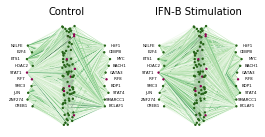

In [200]:
plt.figure(figsize=(4.5, 2), frameon=False)
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.1)

edge_colors = np.array([ctrl_G[u][v]['weight'] for u,v in ctrl_G.edges])
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    with_labels=False, 
    width=[0.01 if source in all_genes_considered and sink in all_genes_considered else 0.5 for source, sink in ctrl_G.edges()], 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=2,
    edge_vmin=0,
    edge_vmax=0.3,
    node_color=[0 if node in upreg_genes else 1 for node in ctrl_G.nodes()],
    cmap=mpl.cm.PiYG,
    vmin=0,
    vmax=1,
    node_shape='8')
nx.draw_networkx_labels(G=ctrl_G, pos=label_pos, labels={tf:tf for tf in ctrl_tf + stim_tf}, font_size=4)
plt.xlim(-9.5, 9)
plt.axis('off')
plt.title('Control')


plt.subplot(1, 2, 2)
edge_colors = np.array([stim_G[u][v]['weight'] for u,v in stim_G.edges])
nx.draw_networkx(
    stim_G, 
    pos=pos, 
    with_labels=False, 
    width=[0.01 if source in all_genes_considered and sink in all_genes_considered else 0.5 for source, sink in stim_G.edges()], 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=2,
    edge_vmin=0, 
    edge_vmax=0.3,
    node_color=[0 if node in upreg_genes else 1 for node in ctrl_G.nodes()],
    cmap=mpl.cm.PiYG,
    vmin=0,
    vmax=1,
    node_shape='8')
nx.draw_networkx_labels(G=ctrl_G, pos=label_pos, labels={tf:tf for tf in ctrl_tf + stim_tf}, font_size=4)
plt.xlim(-9.5, 9)
plt.axis('off')
plt.title('IFN-B Stimulation')


plt.savefig('network_switching_cd4.png', bbox_inches='tight', dpi=300)

In [121]:
%matplotlib inline

# DEBUG

In [866]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, scmemo_old

In [19]:
ct = 'CD14+ Monocytes'

In [20]:
stat1 = get_data('CD14+ Monocytes', 'STAT1')
isg15 = get_data('CD14+ Monocytes', 'ISG15')

NameError: name 'get_data' is not defined

In [21]:
idx_1 = adata.var.index.tolist().index('STAT1')
idx_2 = adata.var.index.tolist().index('ISG15')
print(
    adata.var.index.tolist().index('STAT1'),
    adata.var.index.tolist().index('ISG15'))

587 2


In [22]:
old_estimator = scmemo_old.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

old_estimator.estimate_beta_sq(tolerance=3)
old_estimator.estimate_parameters()
# old_estimator.estimate_2d_parameters(
#     gene_list_1=['STAT1'], 
#     gene_list_2=['ISG15'],
#     groups=[ct + ' - ctrl', ct + ' - stim'])

NameError: name 'scmemo_old' is not defined

In [882]:
old_estimator.parameters['{} - stim'.format(ct)]['corr'][idx_1, idx_2]

0.06896814069122358

In [183]:
adata_all.X.max(axis=0).toarray()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [280]:
adata_all = sc.read(data_path + 'interferon.h5ad')
adata_all.obs['n_counts'] = adata_all.X.sum(axis=1)
adata_all.var['n_max'] = adata_all.X.max(axis=0).toarray()[0]
adata_all.var['n_cell'] = (adata_all.X > 0).sum(axis=0).A1

adata_all = adata_all[:, adata_all.var['n_cell'] > 500].copy()

In [281]:
adata_all.shape

(29065, 5485)

In [282]:
means = adata_all.X.toarray().mean(axis=0)
variances = adata_all.X.toarray().var(axis=0)
cv_sq = variances/means**2

In [283]:
(means < variances).mean()

0.9996353691886964

In [284]:
(means > variances).mean()

0.00036463081130355516

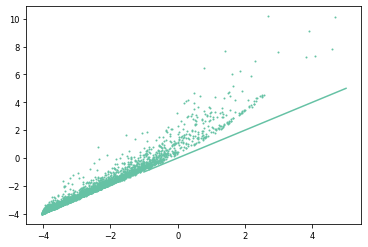

In [285]:
plt.scatter(
    np.log(means),
    np.log(variances),
    s=1
)
plt.plot([-1, 5], [-1,5])

In [288]:
x = means
y = variances

noise_level = np.percentile(
    (y/x**2 - 1/x)[y > x], 
    q=0)

print((noise_level+1)*0.1**2)

0.01196952819824219


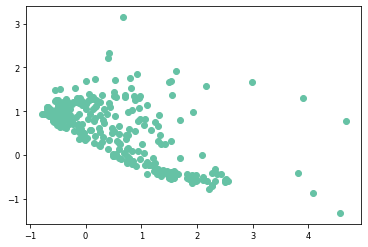

In [264]:
plt.scatter(
    np.log(means),
    np.log(cv_sq)
)

In [253]:
adata_all.shape

(29065, 300)

In [255]:
estimator = scmemo.SingleCellEstimator(
    adata=adata_all, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.compute_observed_moments(verbose=False)

# estimator.estimate_1d_parameters()
# estimator.estimate_2d_parameters(
#     gene_list_1=['STAT1'], 
#     gene_list_2=['ISG15'],
#     groups=[ct + ' - ctrl', ct + ' - stim'])

In [ ]:
estimator.

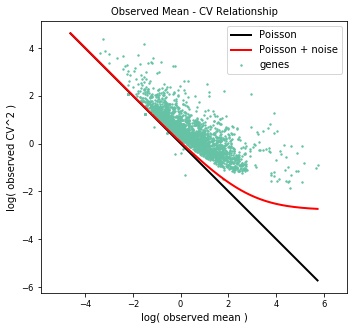

In [256]:
estimator.estimate_beta_sq(tolerance=0)
estimator.plot_cv_mean_curve()

In [206]:
estimator.beta_sq

0.011072496509552004

In [47]:
%matplotlib inline

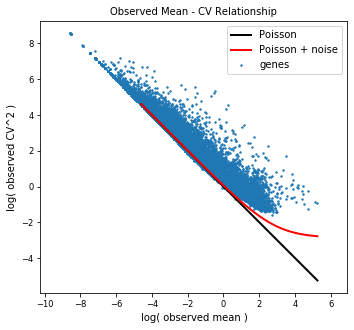

In [48]:
estimator.plot_cv_mean_curve()

In [38]:
estimator.noise_level

0.00038421154022216797

In [37]:
estimator.beta_sq

0.010003842115402223

In [980]:
estimator.parameters['{} - ctrl'.format(ct)]['corr'][idx_1, idx_2]

0.06586212

In [200]:
# Simluate the noise
p = 0.1
noise_level = 0.00038421154022216797
p_sq = 0.01007820664998283
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)
qs = stats.beta.rvs(alpha, beta, size=10000)

(0, 1)

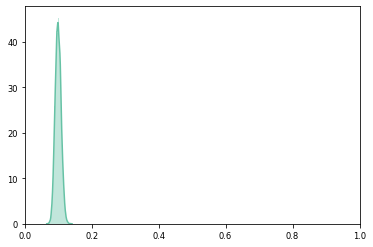

In [201]:
sns.distplot(qs)
plt.xlim(0, 1)

In [967]:
print(estimator.noise_level, estimator.beta_sq)

0.14579722344875334 0.011457972234487534


In [965]:
print(estimator.noise_level, estimator.beta_sq)

0.00038421154022216797 0.010003842115402223


In [959]:
estimator.noise_level

0.14579722344875334

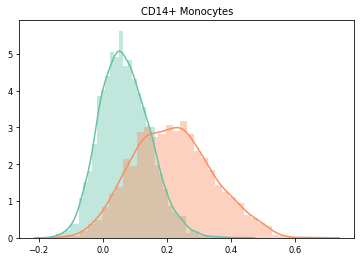

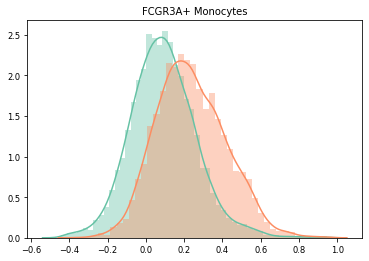

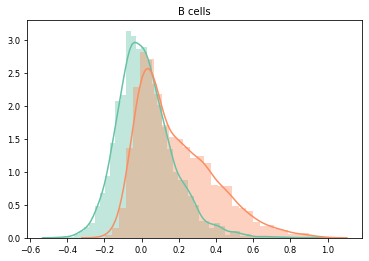

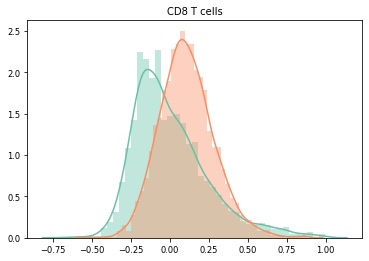

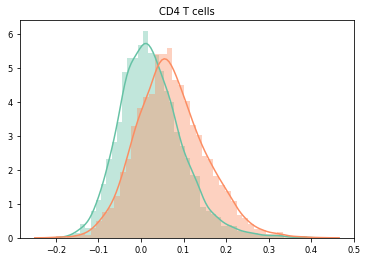

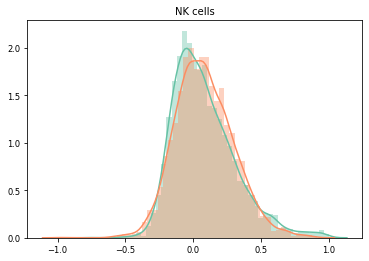

In [986]:
gene = 'STAT1'
for ct in ['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']:

    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)

    estimator.compute_observed_moments(verbose=False)
    estimator.estimate_beta_sq(tolerance=0)
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=[gene], 
        gene_list_2=adata.var.index.tolist(),
        groups=[ct + ' - ctrl', ct + ' - stim'])
    
    idx = adata.var.index.tolist().index(gene)

    stim = estimator.parameters['{} - stim'.format(ct)]['corr'][idx, :].toarray().ravel()
    stim = stim[np.abs(stim) < 1]
    ctrl = estimator.parameters['{} - ctrl'.format(ct)]['corr'][idx, :].toarray().ravel()
    ctrl = ctrl[np.abs(ctrl) < 1]

    plt.figure()
    plt.title(ct)
    sns.distplot(ctrl)
    sns.distplot(stim)

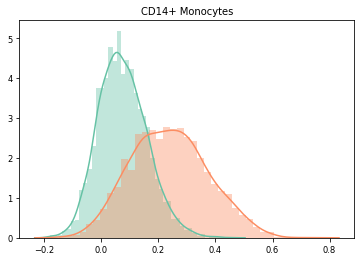

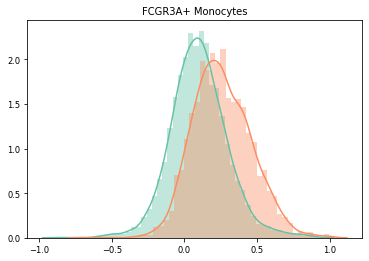

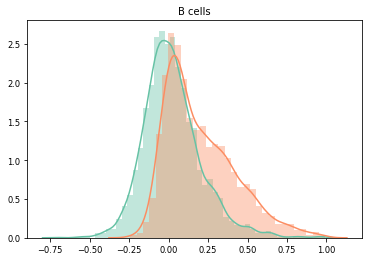

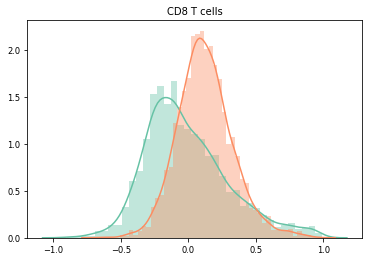

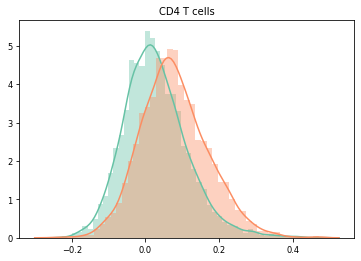

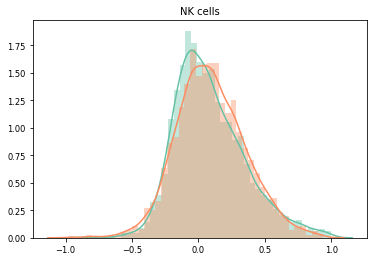

In [984]:
for ct in ['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']:

    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.07)

    estimator.compute_observed_moments(verbose=False)
    estimator.estimate_beta_sq(tolerance=0)
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=['STAT1'], 
        gene_list_2=adata.var.index.tolist(),
        groups=[ct + ' - ctrl', ct + ' - stim'])

    stim = estimator.parameters['{} - stim'.format(ct)]['corr'][idx_1, :].toarray().ravel()
    stim = stim[np.abs(stim) < 1]
    ctrl = estimator.parameters['{} - ctrl'.format(ct)]['corr'][idx_1, :].toarray().ravel()
    ctrl = ctrl[np.abs(ctrl) < 1]

    plt.figure()
    plt.title(ct)
    sns.distplot(ctrl)
    sns.distplot(stim)

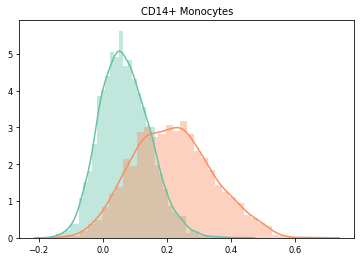

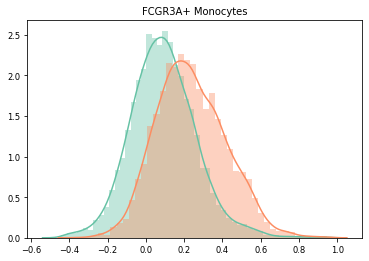

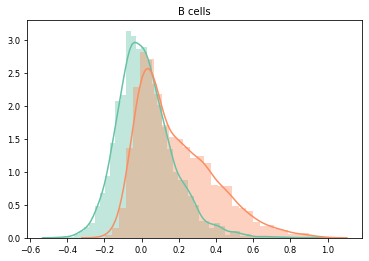

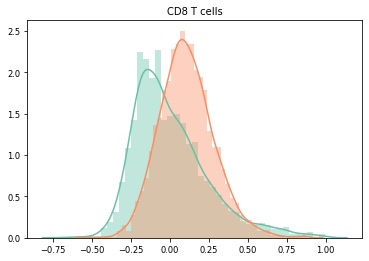

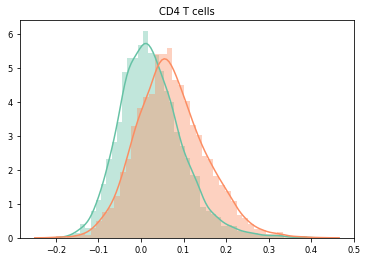

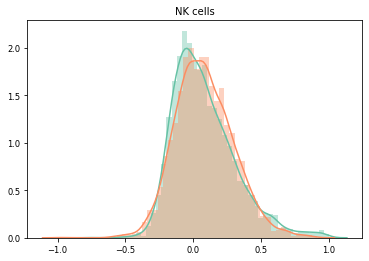

In [945]:
for ct in ['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']:

    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='cell_type',
        n_umis_column='n_counts',
        num_permute=10000,
        beta=0.1)

    estimator.compute_observed_moments(verbose=False)
    estimator.estimate_beta_sq(tolerance=0)
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=['STAT1'], 
        gene_list_2=adata.var.index.tolist(),
        groups=[ct + ' - ctrl', ct + ' - stim'])

    stim = estimator.parameters['{} - stim'.format(ct)]['corr'][idx_1, :].toarray().ravel()
    stim = stim[np.abs(stim) < 1]
    ctrl = estimator.parameters['{} - ctrl'.format(ct)]['corr'][idx_1, :].toarray().ravel()
    ctrl = ctrl[np.abs(ctrl) < 1]

    plt.figure()
    plt.title(ct)
    sns.distplot(ctrl)
    sns.distplot(stim)